In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk
from datetime import date




url="https://uzmanpara.milliyet.com.tr/canli-borsa/bist-TUM-hisseleri/"
r=requests.get(url)
soup=BeautifulSoup(r.content,"html.parser")

bs=BeautifulSoup(r.content, "lxml")
data=soup.find("div",{"class":"box box10 last"})
data


<div class="box box10 last" id="acik_koyu_yeri3">
<table border="0" cellpadding="0" cellspacing="0" class="table3">
<tbody>
<tr><th class="left">Menkul</th>
<th class="currency"></th>
<th class="center">Fiyat</th>
<th class="center td2">%</th>
<th class="center td2">Zaman</th>
</tr>
<tr class="zebra" id="h_tr_id_PKART">
<td class="currency"><a href="/borsa/hisse-senetleri/plastikkart-pkart/" target="_blank"><b id="h_b_ad_id_PKART">PKART</b></a></td>
<td class="currency-up" id="h_td_yon_id_PKART"> </td>
<td class="center" id="h_td_fiyat_id_PKART">22,76</td>
<td class="center" id="h_td_yuzde_id_PKART">1,97</td>
<td class="center" id="h_td_zaman_id_PKART">18:09:39</td>
</tr>
<tr class="zebra" id="h_tr_id_PKENT">
<td class="currency"><a href="/borsa/hisse-senetleri/petrokent-turizm-pkent/" target="_blank"><b id="h_b_ad_id_PKENT">PKENT</b></a></td>
<td class="currency-up" id="h_td_yon_id_PKENT"> </td>
<td class="center" id="h_td_fiyat_id_PKENT">114,60</td>
<td class="center" id="h_td_yuzde_

In [2]:
data=soup.find("tr",{"id":"h_tr_id_KCHOL"})


In [3]:
data=soup.find("td",{"id":"h_td_fiyat_id_KCHOL"})
text=data.text

In [4]:
text=text.replace(',', '.')
text=float(text)
text

99.4

In [2]:
kchol=pd.read_csv("/Users/Bora/Documents/GitHub/Borsa-Hisse-Analizi/kchol.csv")
kchol.index=pd.to_datetime(kchol["Date"])


In [3]:
del kchol["Date"]

In [4]:
kchol=pd.DataFrame(kchol)

In [5]:
kchol

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,20.08,20.00,20.36,19.93,10.53M,0.40%
2021-01-05,20.02,19.89,20.46,19.76,15.65M,-0.30%
2021-01-06,20.02,20.12,20.21,19.76,12.23M,0.00%
2021-01-07,19.98,20.08,20.14,19.78,7.91M,-0.20%
2021-01-08,20.38,20.10,20.38,20.00,10.36M,2.00%
...,...,...,...,...,...,...
2023-06-12,101.00,104.60,105.50,101.00,22.71M,-2.51%
2023-06-13,99.60,100.60,102.50,97.70,30.46M,-1.39%
2023-06-14,99.30,99.95,103.60,98.30,32.30M,-0.30%


In [6]:
close=pd.DataFrame(kchol["Price"])

close


,Price
Date,
2021-01-04,20.08
2021-01-05,20.02
2021-01-06,20.02
2021-01-07,19.98
2021-01-08,20.38
...,...
2023-06-12,101.00
2023-06-13,99.60
2023-06-14,99.30


In [10]:
dict={'Date':date.today(),'Price':text}
df=pd.DataFrame.from_dict(dict,orient="index")
df=df.T
df.reset_index()
df

,Date,Price
0,2023-06-18,99.4


In [11]:
df.set_index=df["Date"]
df

,Date,Price
0,2023-06-18,99.4


In [12]:
df.index=df["Date"]

In [13]:
del df["Date"]

In [14]:
df.index=pd.to_datetime(df.index)
df

,Price
Date,
2023-06-18,99.4


In [15]:
close=pd.concat([close,df])
close

,Price
Date,
2021-01-04,20.08
2021-01-05,20.02
2021-01-06,20.02
2021-01-07,19.98
2021-01-08,20.38
...,...
2023-06-13,99.6
2023-06-14,99.3
2023-06-15,101.0


In [7]:
rolling_app5=close.rolling(window=7).mean()
rolling_app14=close.rolling(window=21).mean()
rolling_app21=close.rolling(window=45).mean()



In [8]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [9]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-03-05,21.86,21.530000,21.248571,20.761778
2021-03-08,21.37,21.525714,21.307143,20.790444
2021-03-09,22.03,21.752857,21.382857,20.835111
2021-03-10,22.20,21.810000,21.450476,20.883556
2021-03-11,22.12,21.861429,21.498095,20.931111
...,...,...,...,...
2023-06-12,101.00,96.828571,85.169048,82.452222
2023-06-13,99.60,98.871429,85.300000,82.932222
2023-06-14,99.30,99.657143,85.876190,83.415556


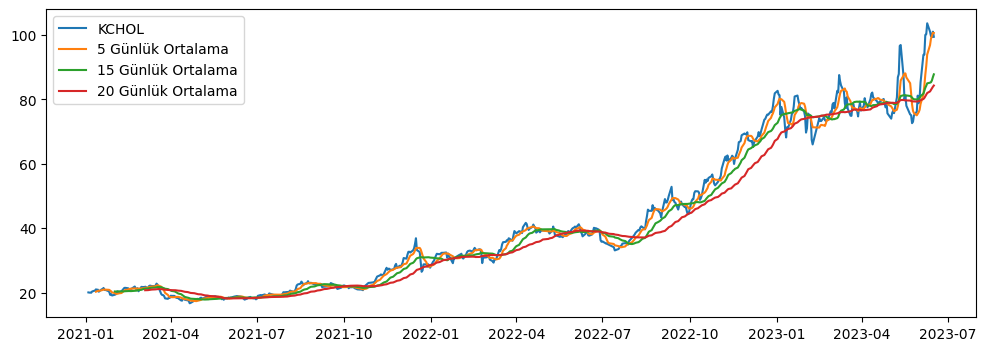

In [10]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='KCHOL')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='15 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='20 Günlük Ortalama')
ax.legend(loc='upper left')


In [11]:
def buy_sell(data,perc=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [12]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

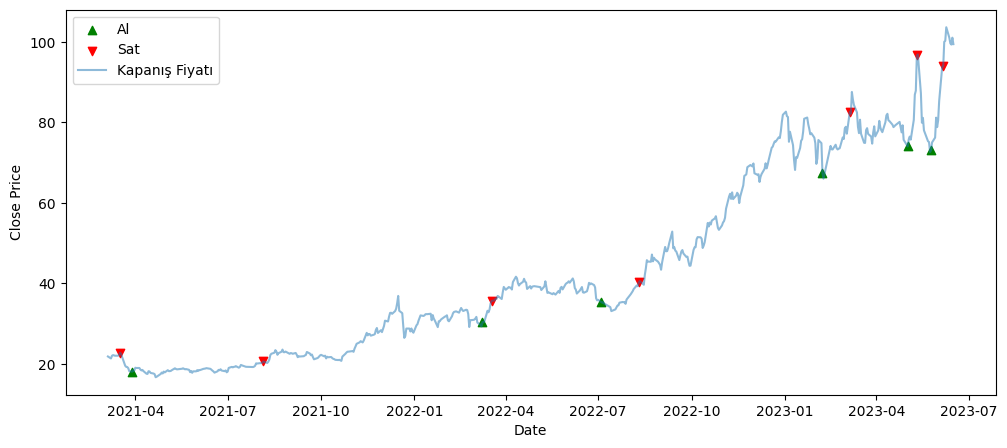

In [13]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [14]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-03-29    18.09
2022-03-09    30.40
2022-07-04    35.38
2023-02-07    67.43
2023-05-02    74.00
2023-05-25    73.05
Name: Al, dtype: float64

In [15]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-03-17    22.81
2021-08-05    20.64
2022-03-18    35.66
2022-08-10    40.24
2023-03-06    82.64
2023-05-11    96.60
2023-06-06    93.90
Name: Sat, dtype: float64

In [21]:
del sat["2021-03-17"]

In [22]:
sat_val=sat.values
al_val=al.values


In [23]:
sat_val1=sat_val

In [24]:
sat_val1

array([20.64, 35.66, 40.24, 82.64, 96.6 , 93.9 ])

In [25]:
al_val1=al_val
al_val1

array([18.09, 30.4 , 35.38, 67.43, 74.  , 73.05])

In [26]:
res=[]

for i in range(6):
    res.append((sat_val1[i]/al_val1[i]))

In [27]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.140962
1,1.173026
2,1.137366
3,1.225567
4,1.305405
5,1.285421


In [28]:
res0=[100]
for i in range(6):
    res0.append(res0[i]*df["Kar"].loc[i])


In [29]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,1.140962,114.096186
1,1.173026,133.837828
2,1.137366,152.222561
3,1.225567,186.558986
4,1.305405,243.535109
5,1.285421,313.045130


In [30]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 213.04513028914428


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [31]:
sat_val2=sat_val[1:6:2]

In [32]:
sat_val2

array([35.66, 82.64, 93.9 ])

In [33]:
al_val2=al_val[0:6:2]
al_val2

array([18.09, 35.38, 74.  ])

In [34]:
res1=[]

for i in range(3):
    res1.append((sat_val2[i]/al_val2[i]))

In [35]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.971255
1,2.335783
2,1.268919


In [36]:
res2=[100]
for i in range(3):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [37]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.971255,197.125484
1,2.335783,460.442340
2,1.268919,584.263996


In [38]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 484.2639956933384
